# Adjacency matrix cluster map
This creates a square matrix of all TFs (1559 x 1559), where rows correspond to TF target roles and columns to TF source roles. A value of 1 indicates an upregulated edge and a value of -1 indicates a downregulated edge. 

In [1]:
import pandas as pd
import numpy as np
# get node list
nodes = pd.read_csv("../kg_assertions_for_neo4j/Transcription Factor.nodes.csv", usecols=['label'])
nodesize = nodes.size
adj_mat = np.zeros([nodesize, nodesize])

In [2]:
upedges = pd.read_csv("../kg_assertions_for_neo4j/Transcription Factor.upregulates.Transcription Factor.edges.csv", usecols=['source_label', 'target_label'])
uplist = list(zip(upedges['source_label'], upedges['target_label']))
dnedges = pd.read_csv("../kg_assertions_for_neo4j/Transcription Factor.downregulates.Transcription Factor.edges.csv", usecols=['source_label','target_label'])
dnlist = list(zip(dnedges['source_label'], dnedges['target_label']))

In [3]:
for (source, target) in uplist:
    sindex = nodes[nodes['label']==source].index[0]
    tindex = nodes[nodes['label']==target].index[0]
    adj_mat[sindex][tindex] = 1

for (source, target) in dnlist:
    sindex = nodes[nodes['label']==source].index[0]
    tindex = nodes[nodes['label']==target].index[0]
    adj_mat[sindex][tindex] = -1

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
adj_df = pd.DataFrame(adj_mat, index=nodes['label'], columns=nodes['label'])

/Users/anna/Projects/TranscriptionNetwork-Demo/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/anna/Projects/TranscriptionNetwork-Demo/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


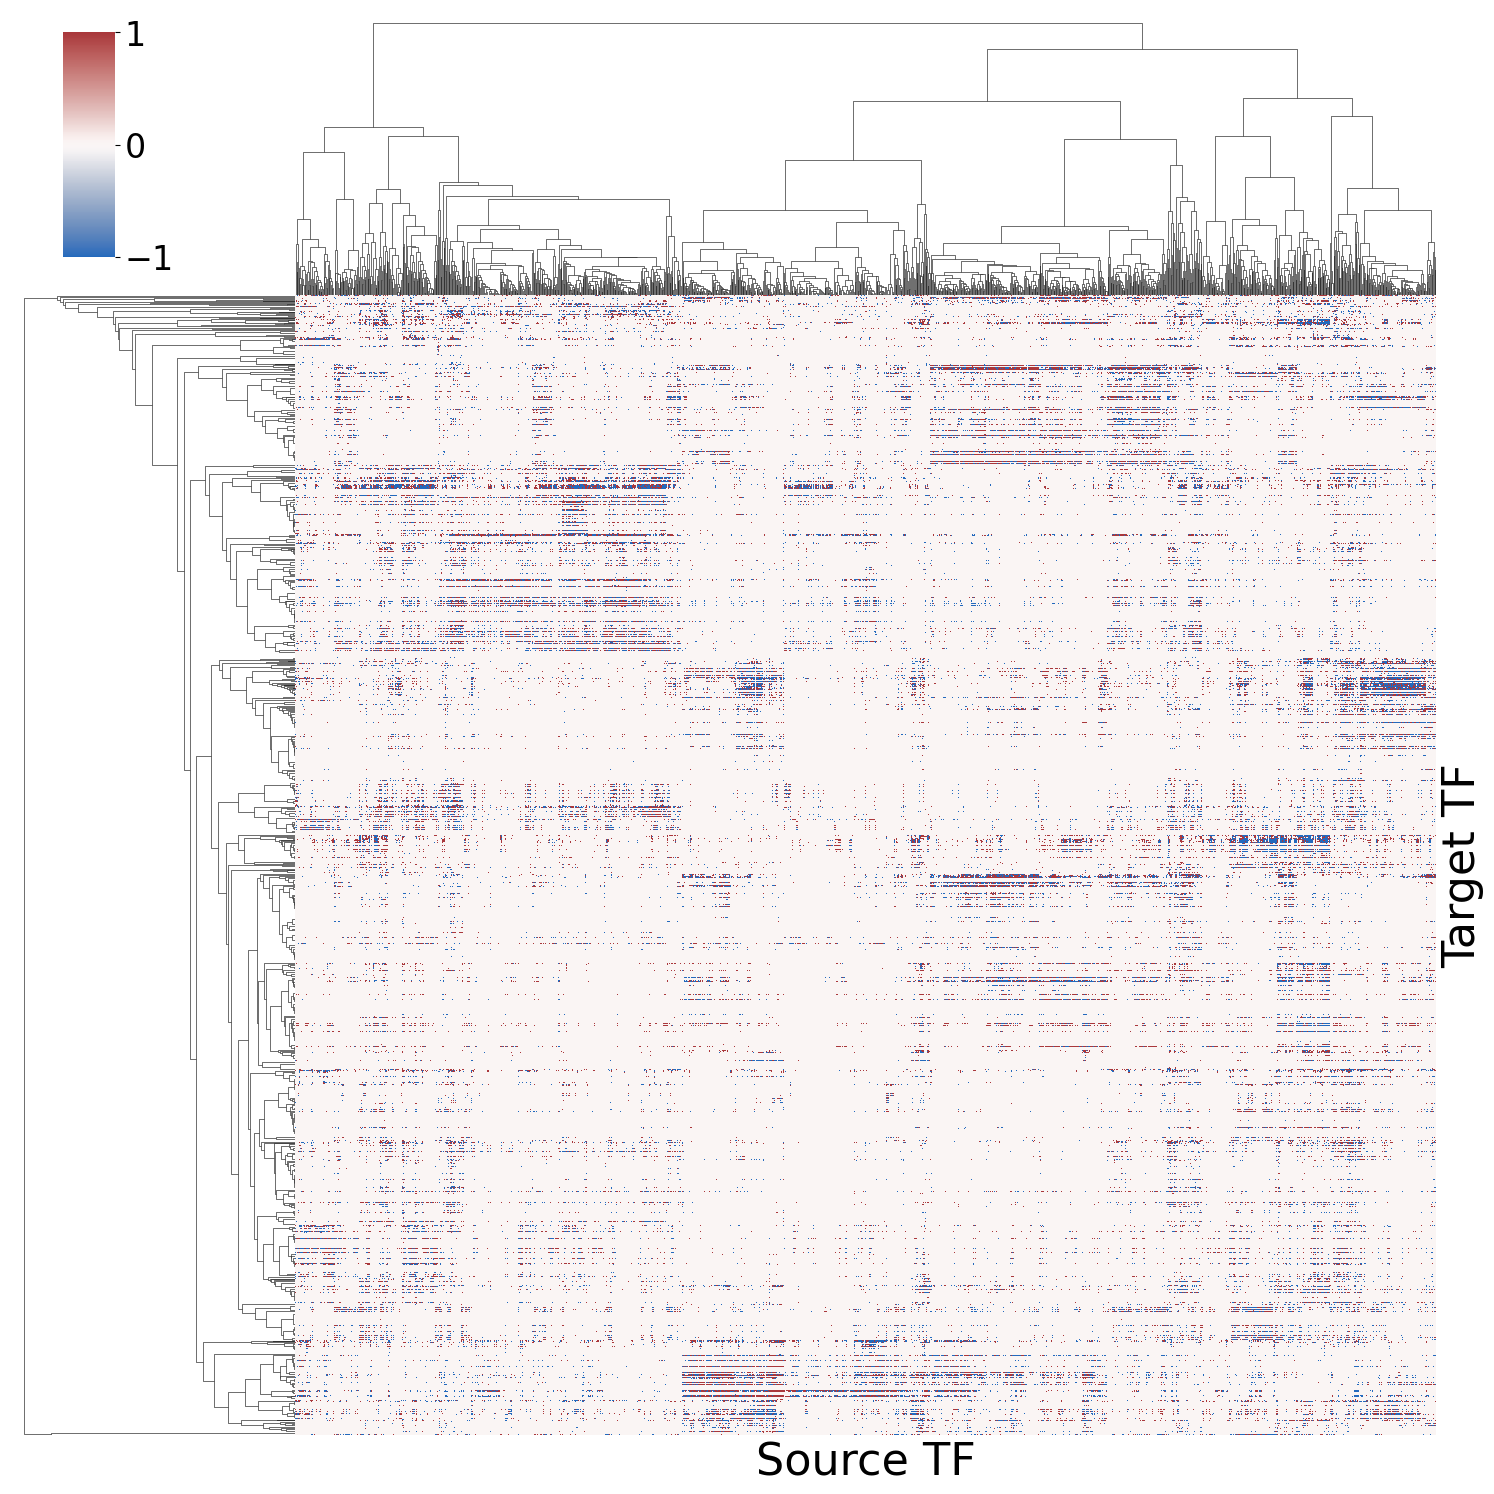

In [6]:
c = sns.clustermap(adj_df, 
                   metric='yule', 
                   cmap='vlag', 
                   xticklabels=False, 
                   yticklabels=False,
                   cbar_pos=(0.05, 0.82, 0.035, 0.15), 
                   cbar_kws={"ticks": [-1,0,1]}
                   )
c.ax_heatmap.set_xlabel("Source TF", fontsize=32)
c.ax_heatmap.set_ylabel("Target TF", fontsize=32)
c.cax.tick_params(labelsize=24)
c.figure.set_figheight(15)
c.figure.set_figwidth(15)
# c.figure.savefig('clustermap.png',dpi=600)


## Excluding target-only nodes (Fig S2)
Next, we reproduce the same heatmap, excluding the nodes that only act as targets. This condenses the matrix to remove empty rows. 

In [7]:
# collect unique sources and targets for both the up and down edges
alledges = pd.concat([upedges, dnedges])
targets = alledges['target_label'].unique()
sources = alledges['source_label'].unique()

# find the list of nodes that are both sources and targets
st_nodes = set(targets) & set(sources)

# only keep edges where both nodes are sources and targets
upedges0 = upedges[upedges['target_label'].isin(st_nodes)]
upedges_st = upedges0[upedges0['source_label'].isin(st_nodes)]
uplist_st = list(zip(upedges_st['source_label'], upedges_st['target_label']))

dnedges0 = dnedges[dnedges['target_label'].isin(st_nodes)]
dnedges_st = dnedges0[dnedges0['source_label'].isin(st_nodes)]   
dnlist_st = list(zip(dnedges_st['source_label'], dnedges_st['target_label']))


In [8]:
# combine all edges into one
all_st_edges = pd.concat([upedges_st, dnedges_st])

# create dataframe and adjacency matrix
st_nodes = pd.DataFrame(st_nodes, columns=['label'])
st_nodesize = st_nodes.size
adj_mat_st = np.zeros([st_nodesize, st_nodesize])
adj_mat_up = np.zeros([st_nodesize, st_nodesize])
adj_mat_dn = np.zeros([st_nodesize, st_nodesize])

In [9]:
for (source, target) in uplist_st:
    sindex = st_nodes[st_nodes['label']==source].index[0]
    tindex = st_nodes[st_nodes['label']==target].index[0]
    adj_mat_st[sindex][tindex] = 1
    adj_mat_up[sindex][tindex] = 1

for (source, target) in dnlist_st:
    sindex = st_nodes[st_nodes['label']==source].index[0]
    tindex = st_nodes[st_nodes['label']==target].index[0]
    adj_mat_st[sindex][tindex] = -1
    adj_mat_dn[sindex][tindex] = 1

/Users/anna/Projects/TranscriptionNetwork-Demo/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/anna/Projects/TranscriptionNetwork-Demo/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


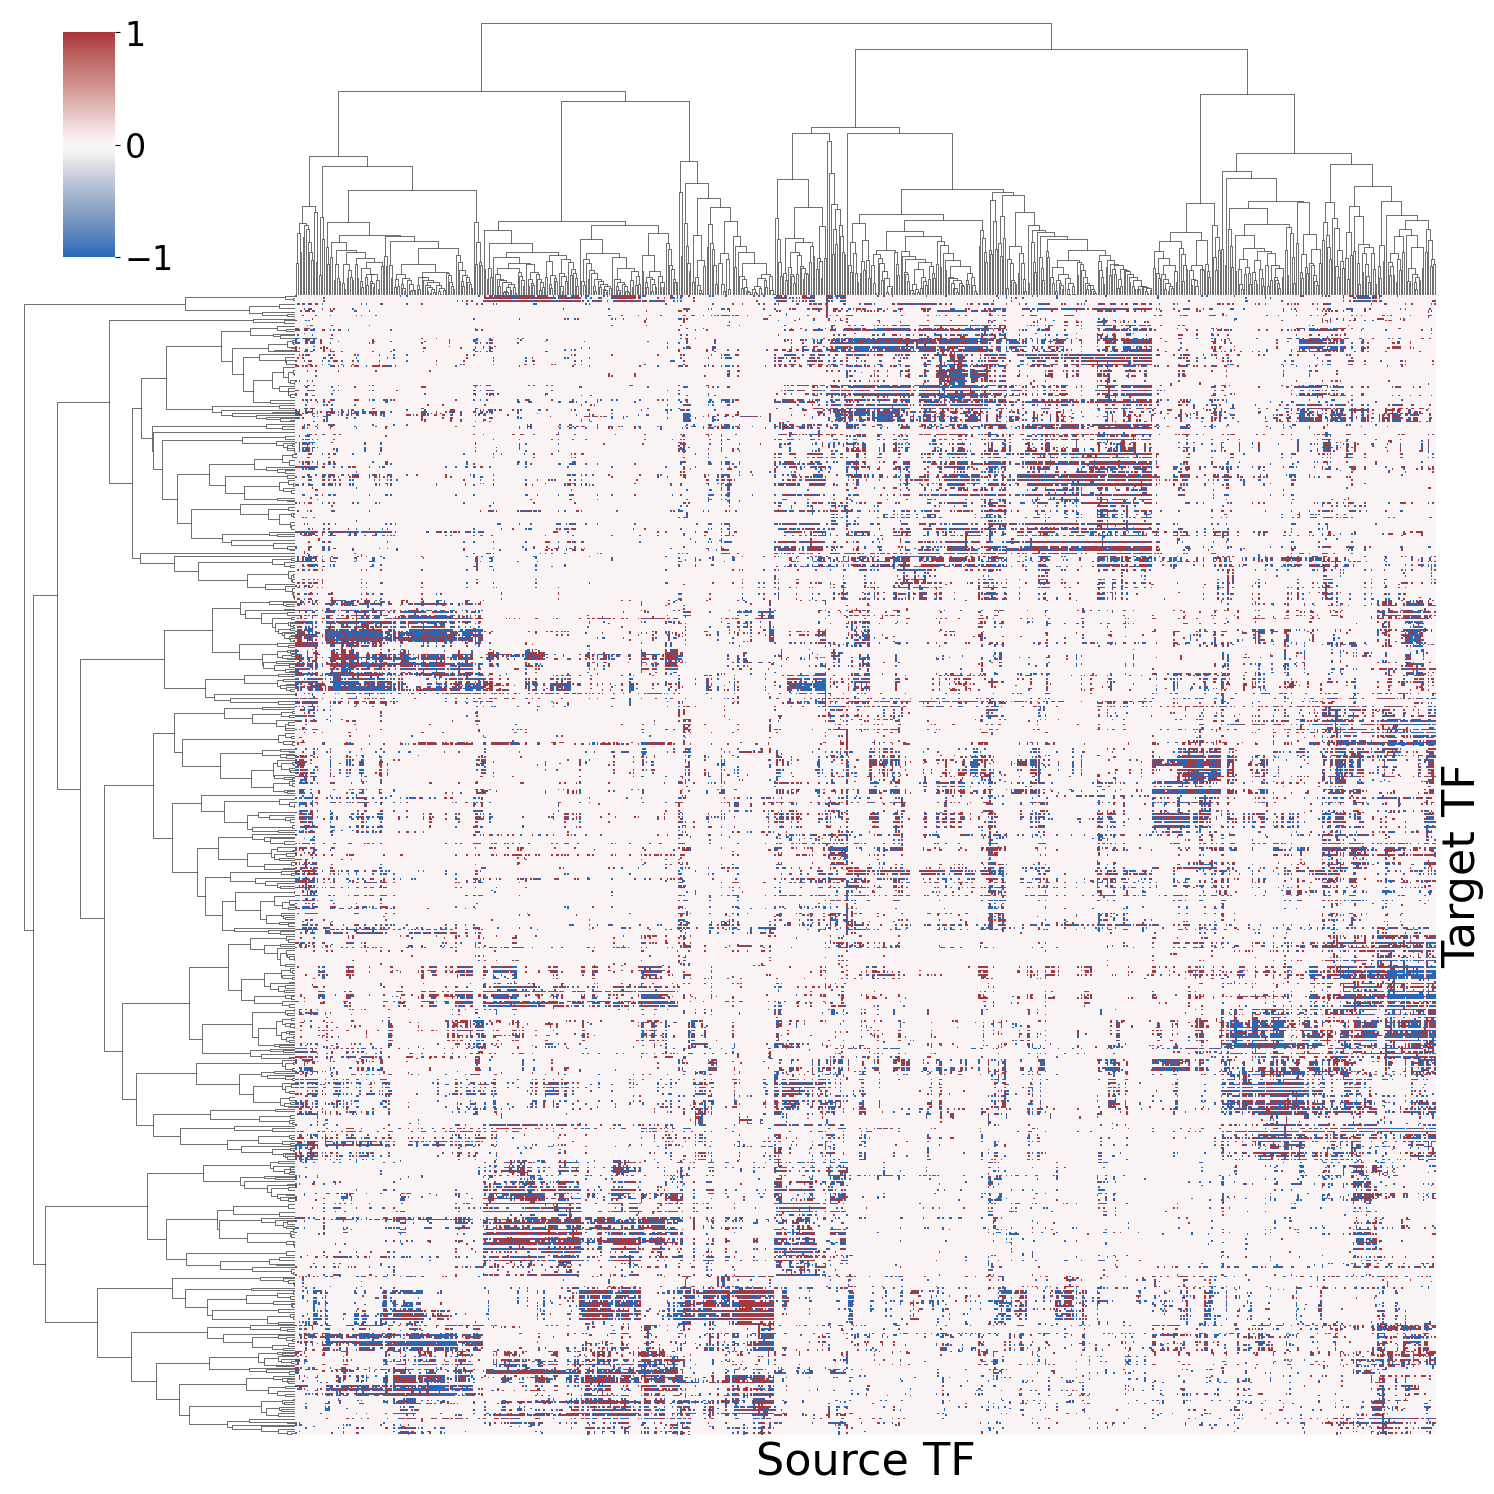

In [10]:
adj_df1 = pd.DataFrame(adj_mat_st, index=st_nodes['label'], columns=st_nodes['label'])
c = sns.clustermap(adj_df1, 
                   metric='yule', 
                   cmap='vlag', 
                   xticklabels=False, 
                   yticklabels=False,
                   cbar_pos=(0.05, 0.82, 0.035, 0.15), 
                   cbar_kws={"ticks": [-1,0,1]}
                   )
c.ax_heatmap.set_xlabel("Source TF", fontsize=32)
c.ax_heatmap.set_ylabel("Target TF", fontsize=32)
c.cax.tick_params(labelsize=24)
c.figure.set_figheight(15)
c.figure.set_figwidth(15)
c.figure.savefig('../../figures/fig5.png', dpi=600)

# Clustermap based on Jaccard similarity scores
Next, we create a clustered heatmap based on jaccard similarity scores between the nodes that act as both sources and targets. 

In [11]:
from scipy.spatial.distance import pdist, squareform

adj_df_abs = pd.DataFrame(abs(adj_mat_st), index=st_nodes['label'], columns=st_nodes['label'])
dist = pdist(adj_df_abs, metric='jaccard')

# convert to MxM matrix where M is the number of nodes
dist = 1-squareform(dist)
distdf = pd.DataFrame(dist, index=st_nodes['label'], columns=st_nodes['label'])

/Users/anna/Projects/TranscriptionNetwork-Demo/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/anna/Projects/TranscriptionNetwork-Demo/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


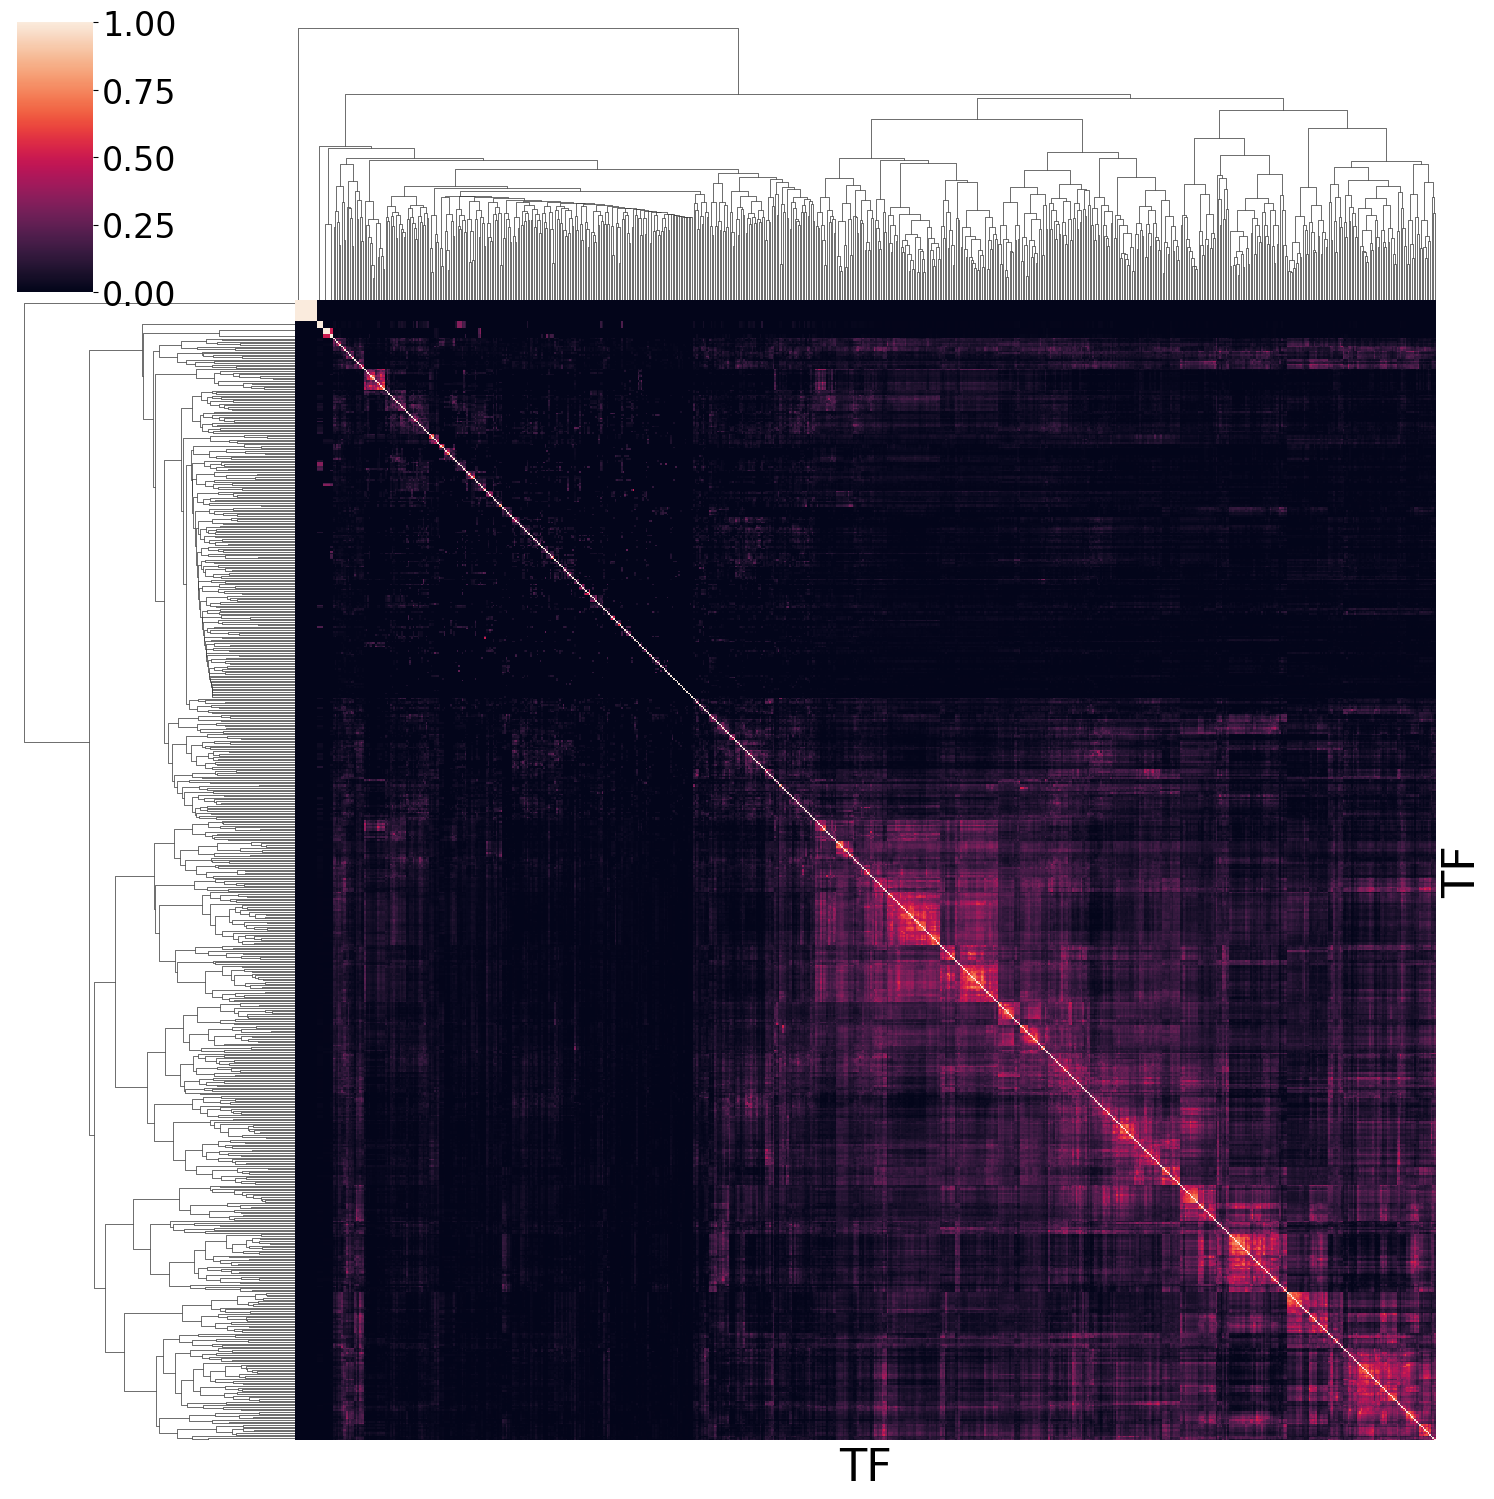

In [12]:
c = sns.clustermap(distdf,
        xticklabels=False, 
        yticklabels=False,
            )

c.figure.set_figheight(15)
c.figure.set_figwidth(15)
c.ax_heatmap.set_xlabel("TF", fontsize=32)
c.ax_heatmap.set_ylabel("TF", fontsize=32)
c.cax.tick_params(labelsize=24)
c.figure.set_figheight(15)
c.figure.set_figwidth(15)
#c.figure.savefig('../../figures/jaccard_sim.png',dpi=600)

## Extracting bottom right square (clade 1)

In [13]:
import scipy.cluster.hierarchy as sch

linkage_matrix = c.dendrogram_row.linkage

# Extract cluster of interest (cluster 1), save TF names from cluster
threshold = 1  
cluster_labels = sch.cut_tree(linkage_matrix, n_clusters=3).flatten()
cluster_df = pd.DataFrame(cluster_labels, columns=['c'])
counts = cluster_df.value_counts()
ct = counts.idxmax() # this gets largest count index
clfs_to_keep = np.array(cluster_df['c']) == ct

# get labels to keep and labels to discard
labels = distdf.index[clfs_to_keep]
to_drop = distdf.index[~clfs_to_keep]

In [14]:
adj_mat_subset = adj_df_abs.drop(columns=to_drop, index=to_drop)
new_dist = pdist(adj_mat_subset, metric='jaccard')

/Users/anna/Projects/TranscriptionNetwork-Demo/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/anna/Projects/TranscriptionNetwork-Demo/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


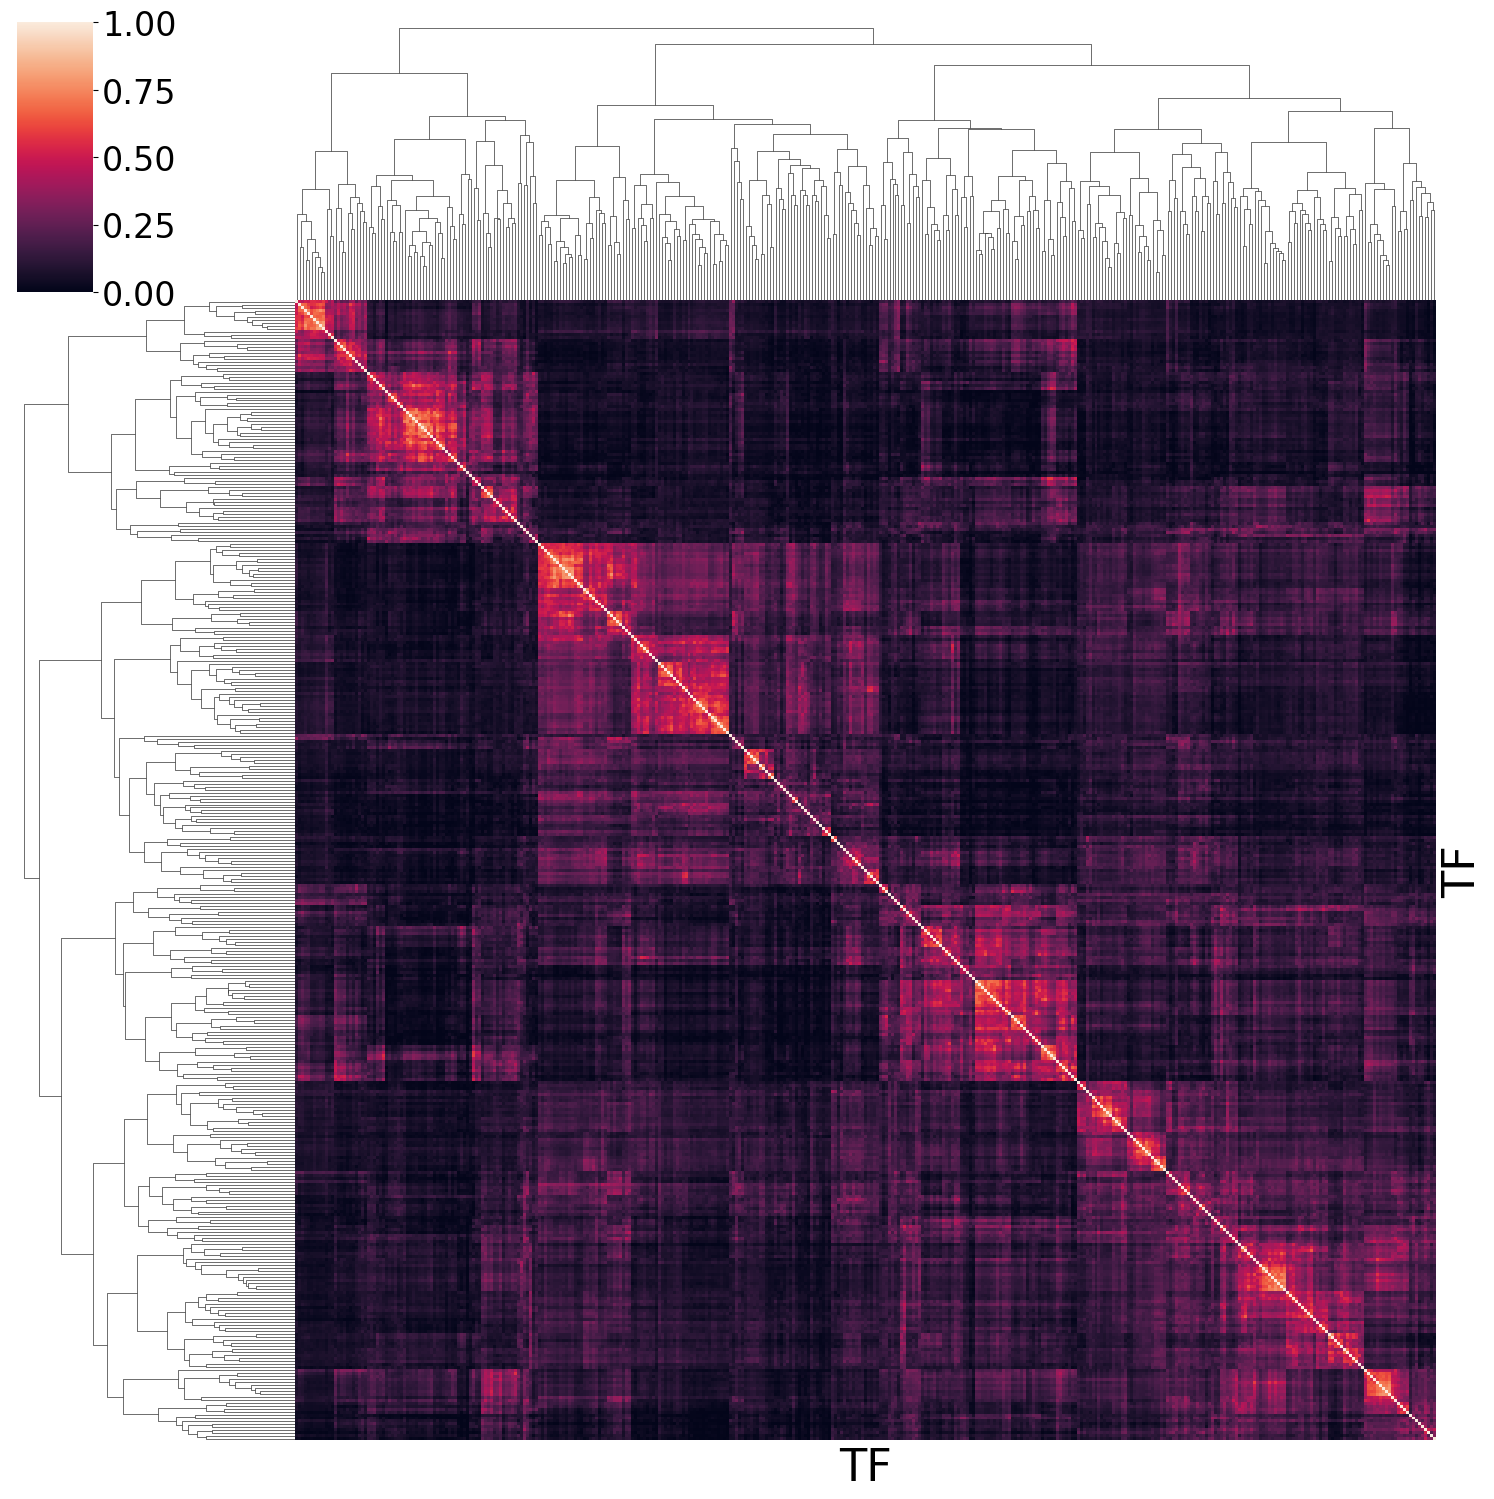

In [15]:
new_dist = 1-squareform(new_dist)
distdf_subset = pd.DataFrame(new_dist, index=labels, columns=labels)

# Plot the new clustermap
cc = sns.clustermap(distdf_subset,
        xticklabels=False, 
        yticklabels=False,
            )

cc.figure.set_figheight(15)
cc.figure.set_figwidth(15)
cc.ax_heatmap.set_xlabel("TF", fontsize=32)
cc.ax_heatmap.set_ylabel("TF", fontsize=32)
cc.cax.tick_params(labelsize=24)
cc.figure.set_figheight(15)
cc.figure.set_figwidth(15)
cc.figure.savefig('../../figures/fig6.png',dpi=600)

plt.show()

## Coloring dendrogram clusters
Finally, we color the dendrogram to extract the relevant clusters. 

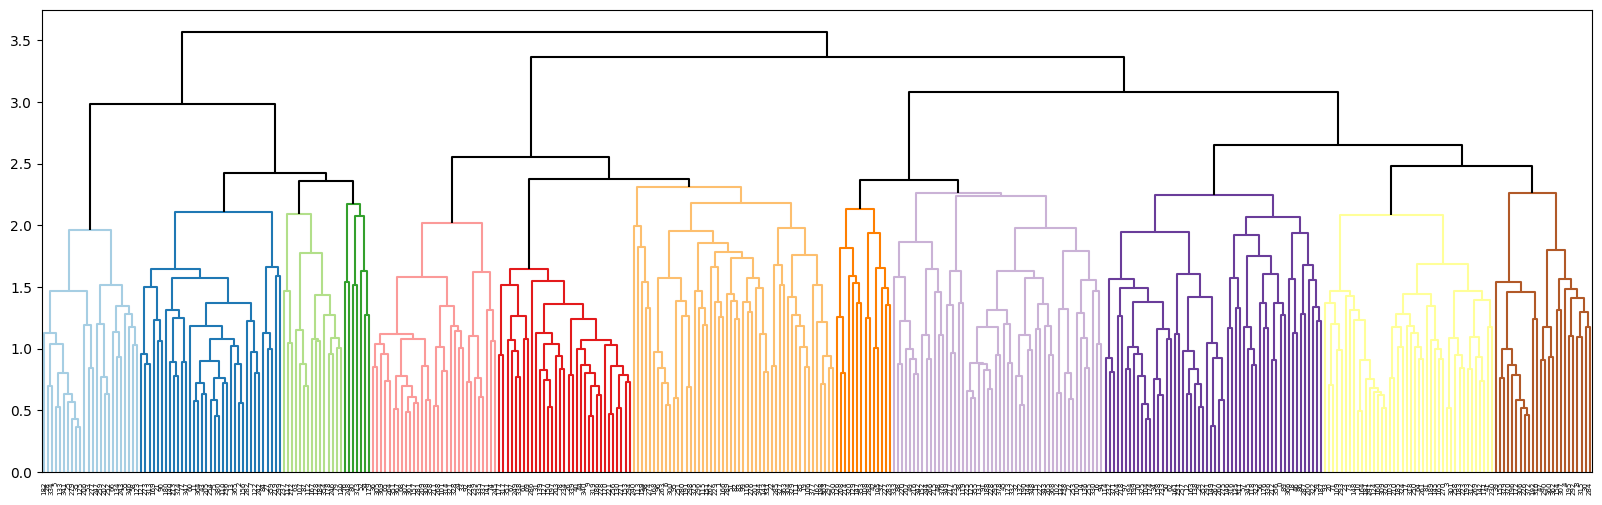

In [16]:
from matplotlib.colors import to_hex
plt.figure(figsize=(20,6))
linkage_matrix2 = cc.dendrogram_row.linkage

# Define the number of unique colors (should be at least as many as merges)
num_clusters = distdf_subset.shape[0] - 1  # Number of merges


color_palette = sns.color_palette("Paired", num_clusters)  # Choose a non-repeating palette
color_palette = [to_hex(c) for c in color_palette]
sch.set_link_color_palette(color_palette)


dendr = sch.dendrogram(linkage_matrix2, color_threshold=0.65*max(linkage_matrix2[:, 2]),above_threshold_color="black")
indices = dendr['leaves']
l = [distdf_subset.columns[i] for i in indices]
dendrogram_df = pd.DataFrame(data = {'leaf':l, 'leaf_color': dendr['leaves_color_list']})
dendrogram_clust = dendrogram_df.groupby('leaf_color')['leaf'].apply(list).reset_index()
plt.savefig("../../figures/dendrogram.svg", format='svg')
plt.show()
